# 데모

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [4]:
data_dir = Path('../data/dacon-dku')
feature_dir = Path('../build/feature')
val_dir = Path('../build/val')
tst_dir = Path('../build/tst')
sub_dir = Path('../build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [5]:
algo_name = 'lgb_hyperopt'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


z    redshift  dered_u  dered_g  dered_r  dered_i  dered_z  \
id                                                                     
0   16.9396 -8.1086e-05  23.1243  20.2578  18.9551  17.6321  16.9089   
1   13.1689  4.5061e-03  14.9664  14.0045  13.4114  13.2363  13.1347   
2   15.3500  4.7198e-04  16.6076  15.6866  15.4400  15.3217  15.2961   
3   19.6346  5.8143e-06  25.3536  20.9947  20.0873  19.7947  19.5552   
4   17.9826 -3.3247e-05  23.7714  20.4338  18.8630  18.1903  17.8759   

    nObserve  airmass_u  class  d_dered_u  d_dered_g  d_dered_r  d_dered_i  \
id                                                                           
0     2.9444     1.1898    0.0    -0.1397    -0.0790    -0.0544    -0.0403   
1     0.6931     1.2533    1.0    -0.0857    -0.0574    -0.0410    -0.0322   
2     1.0986     1.0225    0.0    -0.1787    -0.1388    -0.0963    -0.0718   
3     1.6094     1.2054    0.0    -0.3070    -0.1941    -0.1339    -0.1003   
4     2.6391     1.1939    0.0    -0.6820    -0.2653    -0.1794    -0.1339   

    d_dered_z  d_dered_ig  d_dered_zg  d_dered_rz  d_dered_iz  d_obs_det  
id                                                                        
0     -0.0307     -2.6257     -3.3488      2.0462      0.7232   -15.0556  
1     -0.0343     -0.7683     -0.8698      0.2767      0.1016    -0.3069  
2     -0.0540     -0.3649     -0.3905      0.1440      0.0257    -0.9014  
3     -0.0795     -1.2000     -1.4395      0.5321      0.2395    -1.3906  
4     -0.1067     -2.2436     -2.5579      0.9871      0.3144    -9.3609

In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


## Hyperparameter Tuning

In [8]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [9]:
params = {
    "objective": "multiclass",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [15, 31, 63, 127]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .5, .9, 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100])
}

`hp`는 `hyperopt`에서 불러온 모듈이며 `hp`의 각 함수가 뜻하는 바는 아래와 같습니다. 

- `hp.loguniform("learning_rate", np.log(0.01), np.log(0.3))`: learning_rate를 log(0.01)과 log(0.3) 사이의 임의의 값으로 선택
- `hp.choice("num_leaves", [15, 31, 63, 127])`: num_leaves를 15, 31, 63, 127 중 하나의 값으로 선택
- `hp.quniform("colsample_bytree", .5, .9, 0.1)`: 0.5와 0.9사이의 0.1의 간격을 갖는 값중 하나로 colsample_bytree를 선택

In [10]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|██████████| 10/10 [02:45<00:00, 16.55s/trial, best loss: 0.161683208975629] 
{'objective': 'multiclass', 'n_estimators': 1000, 'subsample_freq': 1, 'random_state': 42, 'n_jobs': -1, 'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.03108434204266342, 'min_child_samples': 10, 'num_leaves': 127, 'subsample': 0.6000000000000001}


## Stratified K-Fold Cross Validation

In [11]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [12]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.954233
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.924743
[3]	valid_0's multi_logloss: 0.894827
[4]	valid_0's multi_logloss: 0.866741
[5]	valid_0's multi_logloss: 0.839951
[6]	valid_0's multi_logloss: 0.816908
[7]	valid_0's multi_logloss: 0.793714
[8]	valid_0's multi_logloss: 0.772796
[9]	valid_0's multi_logloss: 0.753847
[10]	valid_0's multi_logloss: 0.73288
[11]	valid_0's multi_logloss: 0.71286
[12]	valid_0's multi_logloss: 0.693807
[13]	valid_0's multi_logloss: 0.675524
[14]	valid_0's multi_logloss: 0.65779
[15]	valid_0's multi_logloss: 0.641412
[16]	valid_0's multi_logloss: 0.626447
[17]	valid_0's multi_logloss: 0.611459
[18]	valid_0's multi_logloss: 0.596917
[19]	valid_0's multi_logloss: 0.583272
[20]	valid_0's multi_logloss: 0.570976
[21]	valid_0's multi_logloss: 0.557878
[22]	valid_0's multi_logloss: 0.545354
[23]	valid_0's multi_logloss: 0.533336
[24]	valid_0's multi_logloss:

In [13]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.2728%


In [14]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [15]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

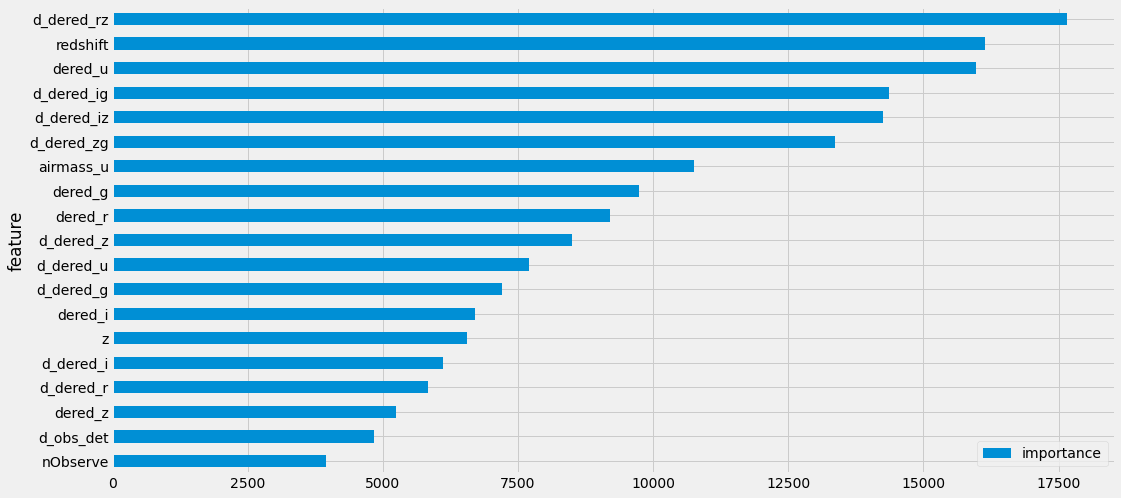

In [16]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [17]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


class
id           
320000      0
320001      0
320002      0
320003      0
320004      0

In [18]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

class
id           
320000      2
320001      0
320002      2
320003      0
320004      2

In [19]:
sub[target_col].value_counts()

2    41076
0    29965
1     8959
Name: class, dtype: int64

In [20]:
sub.to_csv(sub_file)